In [7]:
%pip install yfinance scikit-learn matplotlib pandas ipywidgets tqdm


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
from utils.SeriesProcessor import SeriesProcessor
from classes.frameworkDetector.framework_detector import FrameworkDetector

# Importações necessárias (adicione no início do notebook)
import numpy as np
import copy
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from utils import Visualizer

from classes.detectores.ADWINDetector import ADWINDetector
from classes.detectores.DDMDetector import DDMDetector
from classes.detectores.EDDMDetector import EDDMDetector
from classes.detectores.FHDDMDetector import FHDDMDetector
from classes.detectores.HDDM_ADetector import HDDM_ADetector
from classes.detectores.PageHinkleyDetector import PageHinkleyDetector
from classes.detectores.HDDM_WDetector import HDDM_WDetector
from classes.detectores.KSWINDetector import KSWINDetector

# **1. Preparação da Base de Dados**

In [2]:
# Lista de séries temporais disponíveis (para referência)
series = [
    "AAPL",
    "B3SA3.SA",
    "^IXIC",
    "^DJI",
    "^GSPC",
    "^BVSP",
    "USDBRL=X"
]

# Definindo parâmetros para processamento
lags = 5
serie_escolhida = series[-2]  # Exemplo: ^BVSP
print(f"Processando série: {serie_escolhida}")

# Baixando os dados
serie_temporal = SeriesProcessor.baixar_dados(serie_escolhida)

# Normalizando a série temporal
serie_temporal_normalizada = SeriesProcessor.normalizar_serie(serie_temporal)
print(f"Shape da série após normalização: {serie_temporal_normalizada.shape}")

# Gerando janelas temporais (features X e target Y)
X, Y = SeriesProcessor.criar_janela_temporal(serie_temporal_normalizada, lags)
print(f"Shape dos dados de entrada (X): {X.shape}")
print(f"Shape dos dados de saída (Y): {Y.shape}")

# Definindo tamanho do conjunto inicial de treinamento (por exemplo, 20% dos dados)
initial_size = int(0.2 * len(X))
print(f"Tamanho do conjunto inicial de treinamento: {initial_size} amostras")

# Dividindo os dados em conjunto inicial e streaming
X_init = X[:initial_size]
y_init = Y[:initial_size]
X_stream = X[initial_size:]
Y_stream = Y[initial_size:]

print(f"Shape do X_init: {X_init.shape}")
print(f"Shape do Y_init: {y_init.shape}")
print(f"Shape do X_stream: {X_stream.shape}")
print(f"Shape do Y_stream: {Y_stream.shape}")

# Alternativamente, você pode definir um número fixo de amostras iniciais
# Por exemplo, 100 primeiras amostras para treinamento
fixed_initial_size = 100
X_init_fixed = X[:fixed_initial_size]
Y_init_fixed = Y[:fixed_initial_size]
X_stream_fixed = X[fixed_initial_size:]
Y_stream_fixed = Y[fixed_initial_size:]

print("\nCom tamanho fixo:")
print(f"Shape do X_init_fixed: {X_init_fixed.shape}")
print(f"Shape do Y_init_fixed: {Y_init_fixed.shape}")
print(f"Shape do X_stream_fixed: {X_stream_fixed.shape}")
print(f"Shape do Y_stream_fixed: {Y_stream_fixed.shape}")

Processando série: ^BVSP
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Shape da série após normalização: (1244, 1)
Shape dos dados de entrada (X): (1239, 5)
Shape dos dados de saída (Y): (1239, 1)
Tamanho do conjunto inicial de treinamento: 247 amostras
Shape do X_init: (247, 5)
Shape do Y_init: (247, 1)
Shape do X_stream: (992, 5)
Shape do Y_stream: (992, 1)

Com tamanho fixo:
Shape do X_init_fixed: (100, 5)
Shape do Y_init_fixed: (100, 1)
Shape do X_stream_fixed: (1139, 5)
Shape do Y_stream_fixed: (1139, 1)


In [3]:
# 2. Dados Reais de Séries Financeiras
def preparar_dados_financeiros(ticker="^BVSP", periodo="5y", lags=10):
    """Prepara dados de séries financeiras para experimentos"""
    print(f"Baixando dados para {ticker} nos últimos {periodo}...")

    # Baixar dados
    serie_temporal = SeriesProcessor.baixar_dados(ticker, periodo)

    # Pré-processamento
    serie_normalizada = SeriesProcessor.normalizar_serie(serie_temporal)

    # Criar janelas temporais
    X, y = SeriesProcessor.criar_janela_temporal(serie_normalizada, lags)

    print(f"Dados processados: {X.shape[0]} amostras com {X.shape[1]} features")

    return X, y, serie_temporal

In [4]:
# --- SEÇÃO: INICIALIZAÇÃO DO FRAMEWORK ---

# Definir parâmetros importantes (ajuste conforme necessário)
tamanho_janela = 100      # Tamanho da janela deslizante para avaliação e retreino
detector_escolhido = "KSWIN" # Escolha entre "DDM", "ADWIN", "KSWIN", "HDDM_W"
limiar_mse_retreino = 0.1 # Limiar de MSE para decidir se retreina ou usa modelo do pool

print("\n=== Inicialização do Framework ===")

# 1. Treinar Modelos Iniciais e Obter Scaler
#    Usa X_init, y_init definidos anteriormente
print(f"Treinando modelos iniciais com {len(X_init)} amostras...")
pool_modelos, scaler = FrameworkDetector.treinar_modelos_iniciais(X_init, y_init) # Use y_init (minúsculo como no seu código)

if not pool_modelos:
    raise RuntimeError("Falha crítica: Não foi possível treinar nenhum modelo inicial.")

# 2. Selecionar Modelo Inicial Ativo
modelo_atual = pool_modelos[0] # Começa com o primeiro modelo treinado
print(f"\nModelo inicial ativo: {modelo_atual.nome if hasattr(modelo_atual, 'nome') else type(modelo_atual).__name__}")

# 3. Inicializar Detector
print(f"Inicializando detector: {detector_escolhido}")
# Instanciar o detector escolhido (adicione/ajuste parâmetros conforme necessário)
if detector_escolhido == "DDM":
    detector_wrapper = DDMDetector()
elif detector_escolhido == "ADWIN":
    detector_wrapper = ADWINDetector(delta=0.002)
elif detector_escolhido == "KSWIN":
    # Exemplo: Ajuste alpha, window_size, stat_size
    detector_wrapper = KSWINDetector()
elif detector_escolhido == "HDDM_W":
     detector_wrapper = HDDM_WDetector()
else:
    raise ValueError(f"Detector '{detector_escolhido}' não suportado ou não definido.")

# 4. Inicializar Janela de Dados Recentes
#    Pré-popular a janela com os últimos dados do conjunto inicial
print(f"Inicializando janela de dados com as últimas {min(tamanho_janela, len(X_init))} amostras iniciais.")
# Usa X_init, y_init (minúsculo como no seu código)
janela_dados_recentes = list(zip(X_init[-tamanho_janela:], y_init[-tamanho_janela:]))

# 5. Estruturas para armazenar resultados do stream
erros_predicao_stream = []
estados_detector_stream = []
pontos_drift_detectados = []
metricas_rmse_stream = []
metricas_mae_stream = []
metricas_r2_stream = []
modelo_ativo_ao_longo_do_tempo = []

/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



=== Inicialização do Framework ===
Treinando modelos iniciais com 247 amostras...
Ajustando Scaler nos dados iniciais...
✓ Scaler ajustado e aplicado.

Iniciando treinamento dos modelos iniciais...
  Treinando modelo SVR...
  ✅ Modelo SVR treinado com sucesso
  Treinando modelo Random Forest...
  ✅ Modelo Random Forest treinado com sucesso
  Treinando modelo KNN...
  ✅ Modelo KNN treinado com sucesso

✓ Treinamento inicial concluído. Modelos no pool: 3

Modelo inicial ativo: SVRModelo
Inicializando detector: KSWIN
Inicializando janela de dados com as últimas 100 amostras iniciais.


# **2. Inicialização**

In [5]:
# --- SEÇÃO: LOOP PRINCIPAL DE DETECÇÃO E ADAPTAÇÃO ---

print("\n=== Iniciando Processamento do Stream ===")
# Usa X_stream, Y_stream (maiúsculo como no seu código)
print(f"Processando {len(X_stream)} amostras...")

# Importar bibliotecas para o loop
from tqdm.notebook import tqdm
import time
import numpy as np
import copy
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from classes.modelosOffline.LinearRegressionModelo import LinearRegressionModelo
from classes.modelosOffline.RandomForestModelo import RandomForestModelo # Para retreino

start_time = time.time()

# Usa X_stream, Y_stream (maiúsculo como no seu código)
# Usa initial_size (minúsculo como no seu código)
for i, (x_t, y_t) in enumerate(tqdm(zip(X_stream, Y_stream), total=len(X_stream), desc="Stream")):
    indice_global = initial_size + i # Índice em relação ao dataset completo

    # --- 1. Predição ---
    try:
        x_t_reshaped = x_t.reshape(1, -1)
        x_t_scaled = scaler.transform(x_t_reshaped) # Escalar antes da predição
        y_pred = modelo_atual.prever(x_t_scaled)[0]
    except Exception as e:
        print(f"\n⚠️ Erro na predição na amostra {indice_global}: {e}")
        y_pred = np.mean([y for _, y in janela_dados_recentes]) if janela_dados_recentes else np.mean(y_init)
        print(f"  Usando predição de fallback: {y_pred:.4f}")

    # --- 2. Cálculo do Erro e Atualização do Detector ---
    erro = abs(y_t - y_pred)
    try:
        detector_wrapper.atualizar(erro)
    except Exception as e:
         print(f"\n⚠️ Erro ao atualizar detector na amostra {indice_global}: {e}")

    # --- 3. Obter Estado do Detector ---
    estado = FrameworkDetector.get_state(detector_wrapper)

    # --- 4. Ação Baseada no Estado ---
    if estado == "NORMAL":
        pass # Janela atualizada no final

    elif estado == "ALERTA":
        if hasattr(modelo_atual, "partial_fit"):
            try:
                x_t_scaled_partial = scaler.transform(x_t.reshape(1, -1))
                modelo_atual.partial_fit(x_t_scaled_partial, np.array([y_t]))
            except Exception as e:
                pass
        pass # Janela atualizada no final

    elif estado == "MUDANÇA":
        pontos_drift_detectados.append(indice_global)
        print(f"\n!!! Drift detectado no índice global {indice_global} (Detector: {detector_escolhido}) !!!")

        print(f"  Adicionando cópia de '{modelo_atual.nome if hasattr(modelo_atual, 'nome') else type(modelo_atual).__name__}' ao pool.")
        pool_modelos.append(copy.deepcopy(modelo_atual))
        print(f"  Tamanho do pool agora: {len(pool_modelos)}")

        print("  Selecionando melhor modelo do pool...")
        melhor_modelo = FrameworkDetector.selecionar_melhor_modelo(pool_modelos, janela_dados_recentes, scaler)

        if melhor_modelo:
             print(f"  Avaliando desempenho do melhor modelo selecionado ('{melhor_modelo.nome if hasattr(melhor_modelo, 'nome') else type(melhor_modelo).__name__}')...")
             mse_melhor = FrameworkDetector.desempenho(melhor_modelo, janela_dados_recentes, scaler)
             print(f"  MSE do melhor modelo na janela: {mse_melhor:.4f}. Limiar para retreino: {limiar_mse_retreino:.4f}")

             if mse_melhor < limiar_mse_retreino and mse_melhor != float('inf'):
                 print(f"  ✓ Ativando modelo do pool: {melhor_modelo.nome if hasattr(melhor_modelo, 'nome') else type(melhor_modelo).__name__}")
                 modelo_atual = melhor_modelo
             else:
                 print(f"  Desempenho do melhor modelo do pool não satisfatório ou erro. Treinando novo modelo...")
                 try:
                     novo_modelo_wrapper = RandomForestModelo() # Modelo padrão para retreino
                     X_recente_list = [x for x, _ in janela_dados_recentes]
                     y_recente = np.array([y for _, y in janela_dados_recentes])

                     if len(X_recente_list) >= x_t.shape[0] + 1: # Garante dados suficientes
                         X_recente_scaled = scaler.transform(np.array(X_recente_list)) # Escalar antes de treinar
                         novo_modelo_wrapper.treinar(X_recente_scaled, y_recente)

                         if novo_modelo_wrapper.modelo is not None:
                             modelo_atual = novo_modelo_wrapper
                             print(f"  ✓ Novo modelo ({modelo_atual.nome if hasattr(modelo_atual, 'nome') else type(modelo_atual).__name__}) treinado e ativado.")
                         else:
                              print("  ❌ Falha ao treinar novo modelo, mantendo o melhor do pool.")
                              modelo_atual = melhor_modelo
                     else:
                         print(f"  ⚠️ Janela com poucos dados ({len(X_recente_list)}), não é possível treinar novo modelo. Mantendo o melhor do pool.")
                         modelo_atual = melhor_modelo
                 except Exception as e:
                     print(f"  ❌ Erro ao treinar novo modelo: {e}. Mantendo o melhor do pool.")
                     modelo_atual = melhor_modelo
        else:
            print("  ERRO: Não foi possível selecionar um modelo do pool. Mantendo modelo atual.")

        print("  Reiniciando janela de dados.")
        janela_dados_recentes = [] # Limpa a janela

    # --- 5. Armazenar Resultados da Iteração ---
    erros_predicao_stream.append(erro)
    estados_detector_stream.append(estado)
    modelo_ativo_ao_longo_do_tempo.append(modelo_atual.nome if hasattr(modelo_atual, 'nome') else type(modelo_atual).__name__)

    # Calcular métricas de desempenho periodicamente
    if i > 0 and i % 50 == 0 and len(janela_dados_recentes) > 5:
        try:
            X_janela_eval = np.array([x for x, _ in janela_dados_recentes])
            y_janela_eval = np.array([y for _, y in janela_dados_recentes])
            X_janela_eval_scaled = scaler.transform(X_janela_eval) # Escalar para avaliação
            y_prev_eval = modelo_atual.prever(X_janela_eval_scaled)

            rmse = np.sqrt(mean_squared_error(y_janela_eval, y_prev_eval))
            mae = mean_absolute_error(y_janela_eval, y_prev_eval)
            r2 = r2_score(y_janela_eval, y_prev_eval)

            metricas_rmse_stream.append((indice_global, rmse))
            metricas_mae_stream.append((indice_global, mae))
            metricas_r2_stream.append((indice_global, r2))
        except Exception as e:
            pass

    # --- 6. Adicionar Dado Atual à Janela (FINAL DA ITERAÇÃO) ---
    # Adiciona o dado *original* (não escalado)
    janela_dados_recentes = FrameworkDetector.adicionar_a_janela(
        janela_dados_recentes, (x_t, y_t), tamanho_max=tamanho_janela
    )

# --- Fim do Loop ---
end_time = time.time()
print(f"\n=== Processamento do Stream Concluído ===")
print(f"Tempo total: {end_time - start_time:.2f} segundos")
print(f"Drifts detectados: {len(pontos_drift_detectados)}")
if pontos_drift_detectados:
    print(f"  Nos índices: {pontos_drift_detectados}")
print(f"Tamanho final do pool: {len(pool_modelos)}")


=== Iniciando Processamento do Stream ===
Processando 992 amostras...


Stream:   0%|          | 0/992 [00:00<?, ?it/s]


!!! Drift detectado no índice global 346 (Detector: KSWIN) !!!
  Adicionando cópia de 'SVRModelo' ao pool.
  Tamanho do pool agora: 4
  Selecionando melhor modelo do pool...
  Avaliando 4 modelos do pool na janela (100 amostras)...
  ✓ Melhor modelo selecionado: RandomForestModelo (MSE: 0.1079)
  Avaliando desempenho do melhor modelo selecionado ('RandomForestModelo')...
  MSE do melhor modelo na janela: 0.1079. Limiar para retreino: 0.1000
  Desempenho do melhor modelo do pool não satisfatório ou erro. Treinando novo modelo...


/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


  ✓ Novo modelo (RandomForestModelo) treinado e ativado.
  Reiniciando janela de dados.

!!! Drift detectado no índice global 447 (Detector: KSWIN) !!!
  Adicionando cópia de 'RandomForestModelo' ao pool.
  Tamanho do pool agora: 5
  Selecionando melhor modelo do pool...
  Avaliando 5 modelos do pool na janela (100 amostras)...
  ✓ Melhor modelo selecionado: SVRModelo (MSE: 0.0177)
  Avaliando desempenho do melhor modelo selecionado ('SVRModelo')...
  MSE do melhor modelo na janela: 0.0177. Limiar para retreino: 0.1000
  ✓ Ativando modelo do pool: SVRModelo
  Reiniciando janela de dados.

!!! Drift detectado no índice global 555 (Detector: KSWIN) !!!
  Adicionando cópia de 'SVRModelo' ao pool.
  Tamanho do pool agora: 6
  Selecionando melhor modelo do pool...
  Avaliando 6 modelos do pool na janela (100 amostras)...
  ✓ Melhor modelo selecionado: SVRModelo (MSE: 0.0216)
  Avaliando desempenho do melhor modelo selecionado ('SVRModelo')...
  MSE do melhor modelo na janela: 0.0216. Limiar


=== Análise dos Resultados ===


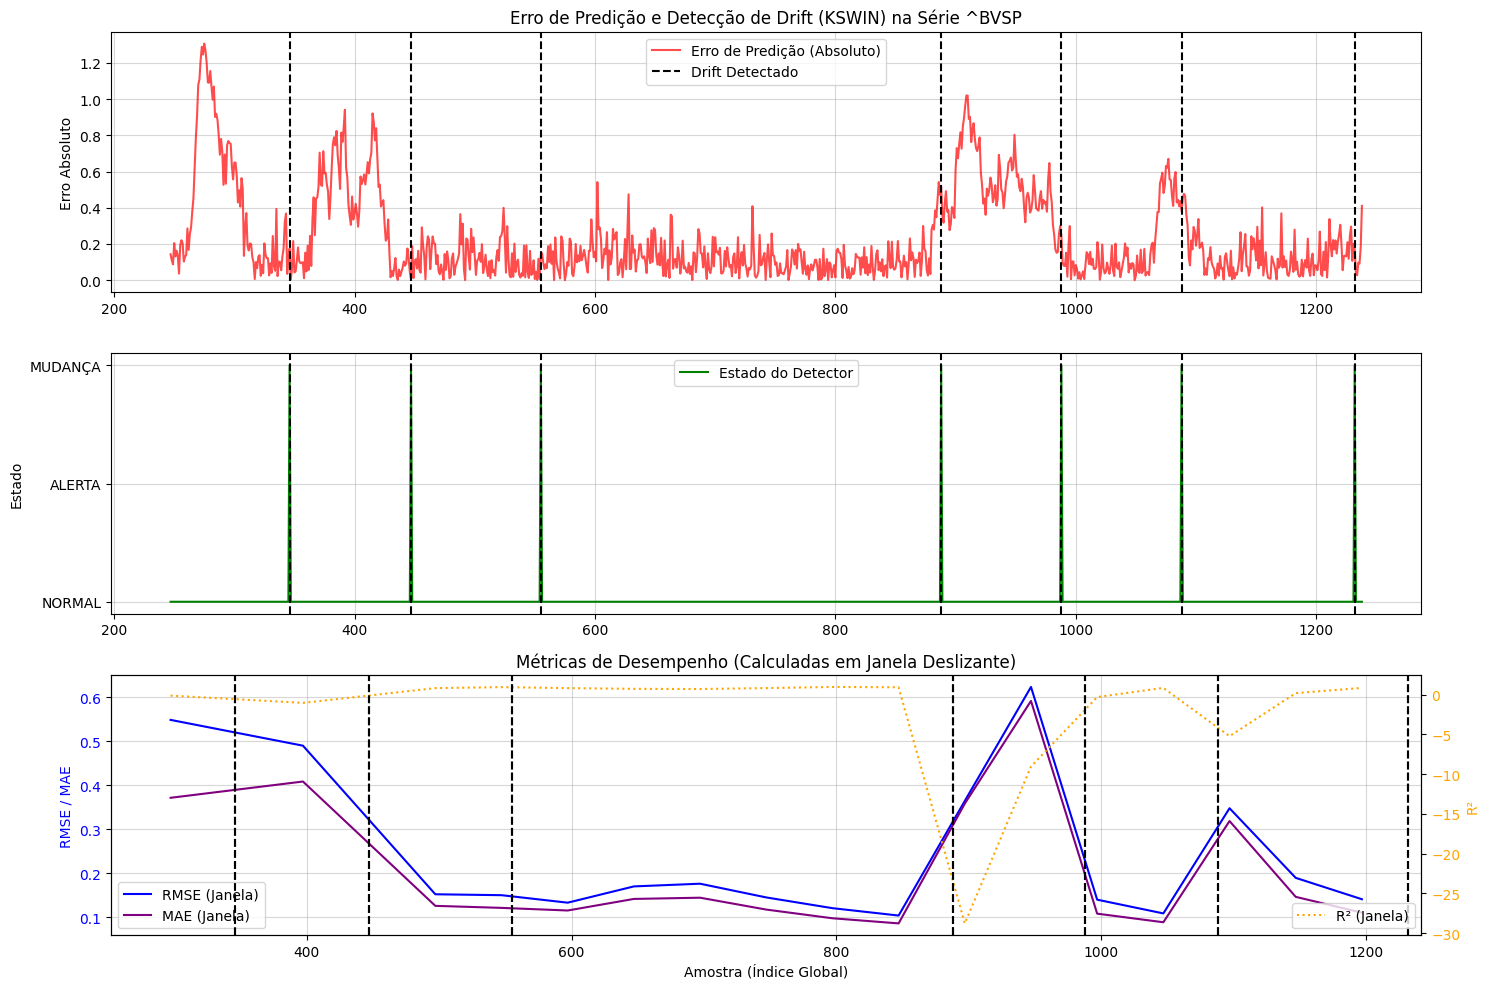


Métricas Globais no Stream:
  MSE: 0.1092
  MAE: 0.2275

Contagem de Uso dos Modelos Durante o Stream:
SVRModelo             540
RandomForestModelo    452
Name: count, dtype: int64


In [6]:
# --- SEÇÃO: ANÁLISE E VISUALIZAÇÃO DE RESULTADOS ---
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np # Certifique-se que numpy está importado

print("\n=== Análise dos Resultados ===")

# Criar eixo de tempo para os resultados do stream
# Usa initial_size (minúsculo como no seu código)
stream_indices = np.arange(initial_size, initial_size + len(erros_predicao_stream))

# Verificar se há resultados para plotar
if not erros_predicao_stream:
    print("Nenhum resultado do stream para analisar.")
else:
    # 1. Gráfico: Erros e Estados do Detector
    plt.figure(figsize=(15, 10))

    plt.subplot(3, 1, 1)
    plt.plot(stream_indices, erros_predicao_stream, label='Erro de Predição (Absoluto)', color='red', alpha=0.7)
    plt.title(f'Erro de Predição e Detecção de Drift ({detector_escolhido}) na Série {serie_escolhida}')
    plt.ylabel('Erro Absoluto')
    plt.grid(True, alpha=0.5)
    # Marcar drifts detectados
    drift_label_added = False
    for ponto in pontos_drift_detectados:
        plt.axvline(x=ponto, color='black', linestyle='--', linewidth=1.5, label='Drift Detectado' if not drift_label_added else "")
        drift_label_added = True
    # Adiciona legenda apenas se houver drifts
    if drift_label_added:
        plt.legend()

    plt.subplot(3, 1, 2)
    estado_map = {"NORMAL": 0, "ALERTA": 1, "MUDANÇA": 2}
    estados_numericos = [estado_map.get(s, -1) for s in estados_detector_stream]
    plt.plot(stream_indices, estados_numericos, label='Estado do Detector', color='green')
    plt.yticks([0, 1, 2], ['NORMAL', 'ALERTA', 'MUDANÇA'])
    plt.ylabel('Estado')
    plt.grid(True, alpha=0.5)
    for ponto in pontos_drift_detectados:
        plt.axvline(x=ponto, color='black', linestyle='--', linewidth=1.5)
    plt.legend()

    # 2. Gráfico: Métricas de Desempenho (RMSE, MAE, R²)
    plt.subplot(3, 1, 3)
    ax_primary = plt.gca() # Eixo Y primário
    legend_handles_primary = []

    if metricas_rmse_stream:
        idx_rmse, val_rmse = zip(*metricas_rmse_stream)
        line_rmse, = ax_primary.plot(idx_rmse, val_rmse, label='RMSE (Janela)', color='blue')
        legend_handles_primary.append(line_rmse)
    if metricas_mae_stream:
        idx_mae, val_mae = zip(*metricas_mae_stream)
        line_mae, = ax_primary.plot(idx_mae, val_mae, label='MAE (Janela)', color='purple')
        legend_handles_primary.append(line_mae)

    ax_primary.set_xlabel('Amostra (Índice Global)')
    ax_primary.set_ylabel('RMSE / MAE', color='blue')
    ax_primary.tick_params(axis='y', labelcolor='blue')
    ax_primary.legend(handles=legend_handles_primary, loc='lower left')
    ax_primary.grid(True, alpha=0.5)

    # Plotar R² em eixo secundário
    if metricas_r2_stream:
        ax_secondary = ax_primary.twinx() # Eixo Y secundário
        idx_r2, val_r2 = zip(*metricas_r2_stream)
        line_r2, = ax_secondary.plot(idx_r2, val_r2, label='R² (Janela)', color='orange', linestyle=':')
        ax_secondary.set_ylabel('R²', color='orange')
        ax_secondary.tick_params(axis='y', labelcolor='orange')
        ax_secondary.legend(handles=[line_r2], loc='lower right')
        # Definir limites para R² se necessário (ex: de -1 a 1)
        # ax_secondary.set_ylim(-1.1, 1.1)

    plt.title('Métricas de Desempenho (Calculadas em Janela Deslizante)')
    # Marcar drifts detectados em ambos os eixos se houver eixo secundário
    for ponto in pontos_drift_detectados:
        ax_primary.axvline(x=ponto, color='black', linestyle='--', linewidth=1.5)
        if 'ax_secondary' in locals():
             ax_secondary.axvline(x=ponto, color='black', linestyle='--', linewidth=1.5)


    plt.tight_layout()
    plt.show()

    # 3. Análise Adicional
    if erros_predicao_stream:
         mse_global_stream = np.mean(np.array(erros_predicao_stream)**2)
         mae_global_stream = np.mean(np.array(erros_predicao_stream))
         print(f"\nMétricas Globais no Stream:")
         print(f"  MSE: {mse_global_stream:.4f}")
         print(f"  MAE: {mae_global_stream:.4f}")

    if modelo_ativo_ao_longo_do_tempo:
        modelos_usados = pd.Series(modelo_ativo_ao_longo_do_tempo).value_counts()
        print("\nContagem de Uso dos Modelos Durante o Stream:")
        print(modelos_usados)